In [1]:
from ietf_wg_mb_extractor import IETF_WG_MB_Extractor
%load_ext autoreload
%autoreload 2
from explore_data import DataExplorer
from prepare_data import DataPreparator

In [2]:
archive_path = 'email-archives/'

extractor = IETF_WG_MB_Extractor(archive_path)
extractor.combine_wg_files(ratio=None)
# Can remove the below getter method, and just return the big df after with combine_wg_files()
active_wg_dataframe = extractor.get_combined_wg_dataframes()
data_preparator = DataPreparator(extractor)

Successfully scraped active WG names
------------------------------------
Successfully extracted names of active WGs existing in files
------------------------------------------------------------
Successfully converted and concatenated all .csv files into one dataframe
-------------------------------------------------------------------------


In [3]:
clean_wg_dataframe = data_preparator.emails_df_cleaning(active_wg_dataframe)
processed_bodies = data_preparator.preprocess_bodies()
text_coll_combined = data_preparator.wg_combined_bodies_to_dict(processed_bodies)
text_coll_default = data_preparator.wg_bodies_to_dict(processed_bodies)

Initial dataframe shape: (532860, 8)
-----------------------------------------
Dataframe shape after cleaning rows: (46956, 9)

------PROCESSING------



100%|██████████| 46956/46956 [01:04<00:00, 724.26it/s] 


Prepocessing time: 64.84 s.

Number of mails removed: 13108
---------------------------------------
Encrypted messages: 3392
Ill from-formated messages: 208
Announc. messages: 4813
Unknown endcoding messages: 62
Empty messages post-processing: 4083
Diff. language: 463
Diverse other noise: 87


In [5]:
train_bodies = data_preparator.prepare_data_for_model(text_coll_default, seed=77, percent_of_data=1)

# Noise that could not have been removed, (NEED THIS TO COUNT TOWARDS OVERALL NUM OF SAMPLES STATISTIC) 
train_bodies = [body for body in train_bodies if 'count bytes who' not in body]

Requested num. of samples: 31749
Actual num. of samples (due to post duplicate-removal): 31169


In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Potential models: roberta-base, bert-base-uncased

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForMaskedLM.from_pretrained("roberta-base") 

In [7]:
model_vocab = tokenizer.vocab.keys()

In [8]:
from nltk.tokenize import word_tokenize
from collections import Counter
from string import punctuation
from nltk.corpus import stopwords

import contractions

# WE SHOULD ADD THIS OR SOIME KIND OF OTHER, BETTER THAN REGULAR SPLIT TOKENIZER TO WHERE WE DO STATISTICS AS WELL

eng_stopwords = stopwords.words('english')

additional_unwanted_tokens = ["''", "``", "'s", "”", "“", "b", "c", "x" "r"]
for ch in additional_unwanted_tokens:
    punctuation += ch

all_tokens = []

for body in train_bodies:
    body = contractions.fix(body)
    tokenized_body = word_tokenize(body)
    for token in tokenized_body:
        if token not in punctuation and token not in eng_stopwords and token not in model_vocab:
            includes_digits = any(chr.isdigit() for chr in token)
            if not includes_digits:
                all_tokens.append(token) 

<BarContainer object of 800 artists>

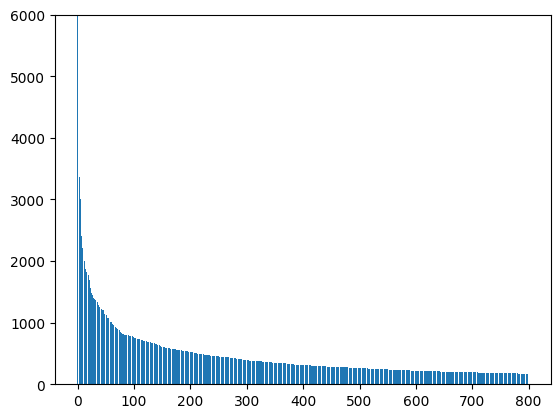

In [9]:
import matplotlib.pyplot as plt

# After 1000k words, it kinda flattens out 
cnt = Counter(all_tokens)
counts = [count for _, count in cnt.most_common(800)]

plt.ylim([0, 6000])
plt.bar(range(len(counts)), counts)

In [ ]:
# Lets see for what percentange of all words does each nth most common word account
total_amount_of_words = len(all_tokens)

accumulated_count = 0
for i, word_count in enumerate(cnt.most_common()):
    accumulated_count += word_count[1]
    print(f'{i} most common word(s) account for {round((accumulated_count / total_amount_of_words)*100, 2)}% of data')
    
# The top 800 words account for rougly 51% of all tokens in our custom data. It is also roughly equal to 1.6% of existing roberta tokens. 

In [14]:
top_800_tokens = [token for token, _ in cnt.most_common(800)]

In [15]:
# Adding domain specific tokens to the tokenizer, modifying models token embedding matrix
_ = tokenizer.add_tokens(top_800_tokens)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 51065. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(51065, 768)

In [31]:
from datasets import Dataset
data = [{'text': list(text)} for text in train_bodies]
dataset = Dataset.from_list(data)

In [32]:
dataset = dataset.train_test_split(test_size=0.10)

In [33]:
dataset['train'][0]

{'text': "as a reminder, we will have an interim on tuesday oct 5th at 1500 utc. the materials will be available at [1] and the webex link is at [2]. i suggest the following familiar-looking draft agenda: - administrivia and agenda bash (chairs, 5 mins) - interop report (marco tiloca, 5 mins) - edhoc open issues (gran selander & john mattsson, nn mins) - aob we are looking for a notetaker. please volunteer by sending an email to the chairs at lake-chairs@[link] if you have any suggested agenda changes please feel free to respond to this mail. if you're mentioned above as a presenter please send any slideware to the chairs or let us know if there's any issue with that."}

In [22]:
def tokenize_function(examples):
    return tokenizer([" ".join(x) for x in examples["text"]])

In [27]:
tokenized_datasets = dataset.map(
    tokenize_function, 
    batched=True)

Map:   0%|          | 0/26449 [00:00<?, ? examples/s]

Map:   0%|          | 0/4668 [00:00<?, ? examples/s]

In [28]:
block_size = 128

In [29]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [30]:
lm_dataset = tokenized_datasets.map(group_texts, batched=True)

Map:   0%|          | 0/26449 [00:00<?, ? examples/s]

TypeError: can only concatenate list (not "str") to list

In [33]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [36]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="roberta_ietf_finetuned",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=data_collator,
)

trainer.train()

  0%|          | 0/11700 [00:00<?, ?it/s]

{'loss': 3.2563, 'learning_rate': 1.914529914529915e-05, 'epoch': 0.13}
{'loss': 2.9905, 'learning_rate': 1.829059829059829e-05, 'epoch': 0.26}
{'loss': 2.8322, 'learning_rate': 1.7435897435897438e-05, 'epoch': 0.38}
{'loss': 2.7553, 'learning_rate': 1.6581196581196585e-05, 'epoch': 0.51}
{'loss': 2.6849, 'learning_rate': 1.5726495726495726e-05, 'epoch': 0.64}
{'loss': 2.6653, 'learning_rate': 1.4871794871794874e-05, 'epoch': 0.77}
{'loss': 2.621, 'learning_rate': 1.4017094017094018e-05, 'epoch': 0.9}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.470242738723755, 'eval_runtime': 17.8041, 'eval_samples_per_second': 315.433, 'eval_steps_per_second': 39.429, 'epoch': 1.0}
{'loss': 2.5851, 'learning_rate': 1.3162393162393164e-05, 'epoch': 1.03}
{'loss': 2.522, 'learning_rate': 1.230769230769231e-05, 'epoch': 1.15}
{'loss': 2.4948, 'learning_rate': 1.1452991452991454e-05, 'epoch': 1.28}
{'loss': 2.4903, 'learning_rate': 1.05982905982906e-05, 'epoch': 1.41}
{'loss': 2.4515, 'learning_rate': 9.743589743589744e-06, 'epoch': 1.54}
{'loss': 2.4597, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}
{'loss': 2.4199, 'learning_rate': 8.034188034188036e-06, 'epoch': 1.79}
{'loss': 2.399, 'learning_rate': 7.17948717948718e-06, 'epoch': 1.92}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.3092458248138428, 'eval_runtime': 17.8421, 'eval_samples_per_second': 314.761, 'eval_steps_per_second': 39.345, 'epoch': 2.0}
{'loss': 2.3887, 'learning_rate': 6.324786324786325e-06, 'epoch': 2.05}
{'loss': 2.3843, 'learning_rate': 5.470085470085471e-06, 'epoch': 2.18}
{'loss': 2.3381, 'learning_rate': 4.615384615384616e-06, 'epoch': 2.31}
{'loss': 2.3437, 'learning_rate': 3.760683760683761e-06, 'epoch': 2.44}
{'loss': 2.3042, 'learning_rate': 2.9059829059829063e-06, 'epoch': 2.56}
{'loss': 2.3095, 'learning_rate': 2.0512820512820513e-06, 'epoch': 2.69}
{'loss': 2.3086, 'learning_rate': 1.1965811965811968e-06, 'epoch': 2.82}
{'loss': 2.3087, 'learning_rate': 3.4188034188034194e-07, 'epoch': 2.95}


  0%|          | 0/702 [00:00<?, ?it/s]

{'eval_loss': 2.2326507568359375, 'eval_runtime': 17.6738, 'eval_samples_per_second': 317.759, 'eval_steps_per_second': 39.72, 'epoch': 3.0}
{'train_runtime': 1237.8985, 'train_samples_per_second': 75.61, 'train_steps_per_second': 9.452, 'train_loss': 2.530918983394264, 'epoch': 3.0}


TrainOutput(global_step=11700, training_loss=2.530918983394264, metrics={'train_runtime': 1237.8985, 'train_samples_per_second': 75.61, 'train_steps_per_second': 9.452, 'train_loss': 2.530918983394264, 'epoch': 3.0})

In [37]:
from transformers import pipeline

mask_filler = pipeline('fill-mask', model=model, tokenizer=tokenizer)